## 1. Trial and Error

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

/bin/bash: nvcc: command not found
gcc (Ubuntu 5.4.0-6ubuntu1~16.04.12) 5.4.0 20160609
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.11.0 False
2.25.0
11.3
GCC 9.3


In [5]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

In [52]:
import os
import re
import string
import os.path as osp

In [77]:
annotation = mmcv.load(image_prefix + jsons[0])

annotations = []
images = []
obj_count = 0

idx = 0

filename = str(annotation['imagePath'])
# print(filename)
img_path = osp.join(image_prefix, filename)
# print(img_path)
height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
# print(height, width)

images.append(dict(
    id=int(idx),
    file_name=filename,
    height=height,
    width=width))

bboxes = []
labels = []
masks = []
for obj in annotation['shapes']:
    px = [points[0] for points in obj['points']]
    py = [points[1] for points in obj['points']]
    poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
    poly = [p for x in poly for p in x]

    x_min, y_min, x_max, y_max = (
        min(px), min(py), max(px), max(py))

    data_anno = dict(
        image_id=idx,
        id=obj_count,
        category_id=0,
        bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
        area=(x_max - x_min) * (y_max - y_min),
        segmentation=[poly],
        iscrowd=0)
    annotations.append(data_anno)
    obj_count += 1    

In [ ]:
annotations

In [66]:
bboxes = []
labels = []
masks = []
for obj in annotation['shapes']:
    px = [points[0] for points in obj['points']]
    py = [points[1] for points in obj['points']]
    poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
    poly = [p for x in poly for p in x]

    x_min, y_min, x_max, y_max = (
        min(px), min(py), max(px), max(py))

    data_anno = dict(
        image_id=idx,
        id=obj_count,
        category_id=0,
        bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
        area=(x_max - x_min) * (y_max - y_min),
        segmentation=[poly],
        iscrowd=0)
    annotations.append(data_anno)
    obj_count += 1    


In [56]:
categories=[{'id':0, 'name': 'shiptrack'}]

In [23]:
from mmcv import Config
cfg = Config.fromfile('/deep/u/mahmedc/mmdetection/configs/solov2/solov2_light_r18_fpn_3x_coco.py')

## 2. Creating Separate Directories for Train, Val, Test Image Copies

In [1]:
import pandas as pd
import string
import shutil
from shutil import copyfile


In [2]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_format/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [4]:
train_csv = pd.read_csv(train_path)

train_img_dir = DATA_DIR + 'train/images/'

for item in train_csv.loc[:,'images_only']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, train_img_dir + image_name)

train_jsons_dir = DATA_DIR + 'train/jsons/'

for item in train_csv.loc[:,'jsons_only']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, train_jsons_dir + json_name)

train_masks_dir = DATA_DIR + 'train/masks/'

for item in train_csv.loc[:,'masks_updated']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, train_masks_dir + mask_name)

In [41]:
val_csv = pd.read_csv(val_path)

val_img_dir = DATA_DIR + 'val/images/'

for item in val_csv.loc[:,'images_only']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, val_img_dir + image_name)

val_jsons_dir = DATA_DIR + 'val/jsons/'

for item in val_csv.loc[:,'jsons_only']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, val_jsons_dir + json_name)

val_masks_dir = DATA_DIR + 'val/masks/'

for item in val_csv.loc[:,'masks_updated']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, val_masks_dir + mask_name)

In [42]:
test_csv = pd.read_csv(test_path)

test_img_dir = DATA_DIR + 'test/images/'

for item in test_csv.loc[:,'images_only']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, test_img_dir + image_name)

test_jsons_dir = DATA_DIR + 'test/jsons/'

for item in test_csv.loc[:,'jsons_only']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, test_jsons_dir + json_name)

test_masks_dir = DATA_DIR + 'test/masks/'

for item in test_csv.loc[:,'masks_updated']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, test_masks_dir + mask_name)

## 3. Converting Train, Val, Test to COCO Format

In [67]:
# Getting all train json files
train_jsons = [f for f in os.listdir(train_jsons_dir)]

# Train Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(train_jsons)):
    annotation = mmcv.load(train_jsons_dir + train_jsons[idx])

    filename = annotation['imagePath']
    # print(filename)
    # img_path = osp.join(image_prefix, filename)
    # print(img_path)
    height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
    # print(height, width)

    images.append(dict(
    id=int(idx),
    file_name=filename,
    height=height,
    width=width))

    bboxes = []
    labels = []
    masks = []
    for obj in annotation['shapes']:
        px = [points[0] for points in obj['points']]
        py = [points[1] for points in obj['points']]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]

        x_min, y_min, x_max, y_max = (
            min(px), min(py), max(px), max(py))

        data_anno = dict(
            image_id=idx,
            id=obj_count,
            category_id=0,
            bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
            area=(x_max - x_min) * (y_max - y_min),
            segmentation=[poly],
            iscrowd=0)
        annotations.append(data_anno)
        obj_count += 1    

out_file = DATA_DIR + 'train/train_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [72]:
# Getting all val json files
val_jsons = [f for f in os.listdir(val_jsons_dir)]

# Val Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(val_jsons)):
    annotation = mmcv.load(val_jsons_dir + val_jsons[idx])

    filename = annotation['imagePath']
    # print(filename)
    # img_path = osp.join(image_prefix, filename)
    # print(img_path)
    height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
    # print(height, width)

    images.append(dict(
    id=int(idx),
    file_name=filename,
    height=height,
    width=width))

    bboxes = []
    labels = []
    masks = []
    for obj in annotation['shapes']:
        px = [points[0] for points in obj['points']]
        py = [points[1] for points in obj['points']]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]

        x_min, y_min, x_max, y_max = (
            min(px), min(py), max(px), max(py))

        data_anno = dict(
            image_id=idx,
            id=obj_count,
            category_id=0,
            bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
            area=(x_max - x_min) * (y_max - y_min),
            segmentation=[poly],
            iscrowd=0)
        annotations.append(data_anno)
        obj_count += 1    

out_file = DATA_DIR + 'val/val_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [79]:
# Getting all test json files
test_jsons = [f for f in os.listdir(test_jsons_dir)]

# Test Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(test_jsons)):
    annotation = mmcv.load(test_jsons_dir + test_jsons[idx])

    filename = annotation['imagePath']
    # print(filename)
    # img_path = osp.join(image_prefix, filename)
    # print(img_path)
    height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
    # print(height, width)

    images.append(dict(
    id=int(idx),
    file_name=filename,
    height=height,
    width=width))

    bboxes = []
    labels = []
    masks = []
    for obj in annotation['shapes']:
        px = [points[0] for points in obj['points']]
        py = [points[1] for points in obj['points']]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]

        x_min, y_min, x_max, y_max = (
            min(px), min(py), max(px), max(py))

        data_anno = dict(
            image_id=idx,
            id=obj_count,
            category_id=0,
            bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
            area=(x_max - x_min) * (y_max - y_min),
            segmentation=[poly],
            iscrowd=0)
        annotations.append(data_anno)
        obj_count += 1    

out_file = DATA_DIR + 'test/test_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

## 4. Repeating Data Processing Steps above for Cropped JSON Files

In [16]:
%reset
import pandas as pd
import string
import shutil
from shutil import copyfile

Nothing done.


In [17]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_format_cropped/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [8]:
train_csv = pd.read_csv(train_path)

train_img_dir = DATA_DIR + 'train/images/'

for item in train_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, train_img_dir + image_name)

train_jsons_dir = DATA_DIR + 'train/jsons/'

for item in train_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, train_jsons_dir + json_name)

train_masks_dir = DATA_DIR + 'train/masks/'

for item in train_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, train_masks_dir + mask_name)

In [9]:
val_csv = pd.read_csv(val_path)

val_img_dir = DATA_DIR + 'val/images/'

for item in val_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, val_img_dir + image_name)

val_jsons_dir = DATA_DIR + 'val/jsons/'

for item in val_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, val_jsons_dir + json_name)

val_masks_dir = DATA_DIR + 'val/masks/'

for item in val_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, val_masks_dir + mask_name)

In [10]:
test_csv = pd.read_csv(test_path)

test_img_dir = DATA_DIR + 'test/images/'

for item in test_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, test_img_dir + image_name)

test_jsons_dir = DATA_DIR + 'test/jsons/'

for item in test_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, test_jsons_dir + json_name)

test_masks_dir = DATA_DIR + 'test/masks/'

for item in test_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, test_masks_dir + mask_name)

In [18]:
train_jsons_dir = DATA_DIR + 'train/jsons/'

# Getting all train json files
train_jsons = [f for f in os.listdir(train_jsons_dir)]

# Train Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(train_jsons)):
    try:
        annotation = mmcv.load(train_jsons_dir + train_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(train_jsons[idx])
    
out_file = DATA_DIR + 'train/train_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [19]:
val_jsons_dir = DATA_DIR + 'val/jsons/'

# Getting all val json files
val_jsons = [f for f in os.listdir(val_jsons_dir)]

# Val Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(val_jsons)):
    try:
        annotation = mmcv.load(val_jsons_dir + val_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(val_jsons[idx])
    
out_file = DATA_DIR + 'val/val_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [20]:
test_jsons_dir = DATA_DIR + 'test/jsons/'

# Getting all test json files
test_jsons = [f for f in os.listdir(test_jsons_dir)]

# Test Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(test_jsons)):
    try:
        annotation = mmcv.load(test_jsons_dir + test_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(test_jsons[idx])
    
out_file = DATA_DIR + 'test/test_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

## 5. Repeating above steps keeping only positives for Training Set

In [1]:
%reset
import pandas as pd
import string
import shutil
from shutil import copyfile
import mmcv

Nothing done.


In [5]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_format_cropped_postrain/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [11]:
train_csv = pd.read_csv(train_path)

train_img_dir = DATA_DIR + 'train/images/'
train_jsons_dir = DATA_DIR + 'train/jsons/'
train_masks_dir = DATA_DIR + 'train/masks/'

for idx in range(len(train_csv)):
    if train_csv.loc[idx, 'contains_shiptrack'] == True:
        image = train_csv.loc[idx,'image']
        image_name = image.split("/")[-1]
        shutil.copyfile(image, train_img_dir + image_name)
        
        json = train_csv.loc[idx,'json']
        json_name = json.split("/")[-1]
        shutil.copyfile(json, train_jsons_dir + json_name)

        mask = train_csv.loc[idx,'mask']
        mask_name = mask.split("/")[-1]
        shutil.copyfile(mask, train_masks_dir + mask_name)

In [12]:
val_csv = pd.read_csv(val_path)

val_img_dir = DATA_DIR + 'val/images/'

for item in val_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, val_img_dir + image_name)

val_jsons_dir = DATA_DIR + 'val/jsons/'

for item in val_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, val_jsons_dir + json_name)

val_masks_dir = DATA_DIR + 'val/masks/'

for item in val_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, val_masks_dir + mask_name)


test_csv = pd.read_csv(test_path)

test_img_dir = DATA_DIR + 'test/images/'

for item in test_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, test_img_dir + image_name)

test_jsons_dir = DATA_DIR + 'test/jsons/'

for item in test_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, test_jsons_dir + json_name)

test_masks_dir = DATA_DIR + 'test/masks/'

for item in test_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, test_masks_dir + mask_name)

In [13]:
train_jsons_dir = DATA_DIR + 'train/jsons/'

# Getting all train json files
train_jsons = [f for f in os.listdir(train_jsons_dir)]

# Train Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(train_jsons)):
    try:
        annotation = mmcv.load(train_jsons_dir + train_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(train_jsons[idx])
    
out_file = DATA_DIR + 'train/train_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [14]:
val_jsons_dir = DATA_DIR + 'val/jsons/'

# Getting all val json files
val_jsons = [f for f in os.listdir(val_jsons_dir)]

# Val Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(val_jsons)):
    try:
        annotation = mmcv.load(val_jsons_dir + val_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(val_jsons[idx])
    
out_file = DATA_DIR + 'val/val_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [15]:
test_jsons_dir = DATA_DIR + 'test/jsons/'

# Getting all test json files
test_jsons = [f for f in os.listdir(test_jsons_dir)]

# Test Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(test_jsons)):
    try:
        annotation = mmcv.load(test_jsons_dir + test_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(test_jsons[idx])
    
out_file = DATA_DIR + 'test/test_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

## 6. Debugging why Positives filter didn't work

In [1]:
%reset
import pandas as pd
import string
import shutil
from shutil import copyfile
import mmcv

In [2]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_format_cropped_postrain/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [2]:
test = mmcv.load('/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_format_cropped_postrain/train/train_annotation_coco.json')

In [3]:
images = test['images']
len(images)

1861

In [6]:
train_csv = pd.read_csv(train_path)

i = 0

for idx in range(len(train_csv)):
    if train_csv.loc[idx, 'contains_shiptrack'] == True:
        i+=1

print(i)

1861


In [7]:
annotations = test['annotations']

In [9]:
image_ids = []

for i in range(len(annotations)):
    image_ids.append(annotations[i]['image_id'])

len(image_ids)

5121

In [10]:
set_ids = set(image_ids)
len(set_ids)

1833

In [12]:
excluded = []
true_image_ids = []

for i in range(len(images)):
    true_image_ids.append(images[i]['id'])

len(true_image_ids)

1861

In [13]:
list_ids = list(set_ids)

for id in true_image_ids:
    if id not in list_ids:
        excluded.append(id)

len(excluded)

28

In [38]:
excluded

[59,
 177,
 194,
 239,
 307,
 351,
 363,
 412,
 589,
 596,
 650,
 871,
 909,
 923,
 972,
 1012,
 1092,
 1166,
 1182,
 1222,
 1251,
 1430,
 1446,
 1500,
 1640,
 1676,
 1757,
 1821]

In [5]:
import numpy as np
test_mask = np.load('/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_format_cropped_postrain/train/masks/myd2008249.1325D_crop_1.npy')

In [16]:
test_mask.shape

(1015, 1354)

In [22]:
np.sum(test_mask)

92310

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from PIL import UnidentifiedImageError
from collections import defaultdict
from shapely.geometry import asLineString, asMultiLineString
from shapely.ops import split

DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/'
JSONS_PATH = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/highres_jsons_cropped_updated/'
img_path = DATA_DIR + 'images_only/'
pts_path = DATA_DIR + 'points_only/myd2008249.1325D.txt'

In [2]:

# Loop over all points files here
# for txt in pts_path:
with open(os.path.join(pts_path)) as f:
    points_list = []
    try:
        for line in f:
            ln = line.strip().split()
            points = [ln[0]] + [int(x) for x in ln[1:]]
            points_list.append(points)
    except UnicodeDecodeError:
        print('UnicodeDecodeError: ', str(os.path.join(pts_path)))

# Loop over all elements in points list here

EPS = 1e-6
coords = points_list
shapes_0 = []
shapes_1 = []
for coord in coords:
    #print(coord)
    # col = colors[coord[0]] # TODO: KeyError: 'EDG'??
    # col = int((i/len(coords))*255)
    coord_y = [coord[i:i + 1][0] for i in range(2, len(coord), 2)]
    coord_x = [coord[i:i + 1][0] for i in range(1, len(coord), 2)]
    smoothnes_raw_x = (np.square(np.std(np.diff(coord_x)))) / (np.abs(np.mean(np.diff(coord_x))) + EPS)
    smoothnes_raw_y = (np.square(np.std(np.diff(coord_y)))) / (np.abs(np.mean(np.diff(coord_y))) + EPS)
    smoothness_raw_avg = 0.5*(smoothnes_raw_x + smoothnes_raw_y)

    coord_proc = [tuple(coord[i:i + 2]) for i in range(1, len(coord), 2)]
    coord_proc.sort(key=lambda y: y[0])
    coord_proc= [item for t in coord_proc for item in t]
    coord_proc_y = [coord_proc[i:i + 1][0] for i in range(1, len(coord_proc), 2)]
    coord_proc_x = [coord_proc[i:i + 1][0] for i in range(0, len(coord_proc), 2)]
    smoothnes_sorted_x = (np.square(np.std(np.diff(coord_proc_x)))) / (np.abs(np.mean(np.diff(coord_proc_x))) + EPS)
    smoothnes_sorted_y = (np.square(np.std(np.diff(coord_proc_y)))) / (np.abs(np.mean(np.diff(coord_proc_y))) + EPS)
    smoothness_sorted_avg = 0.5*(smoothnes_sorted_x + smoothnes_sorted_y)

    coord_proc_2 = [tuple(coord[i:i + 2]) for i in range(1, len(coord), 2)]
    coord_proc_2.sort(key=lambda y: y[1])
    coord_proc_2= [item for t in coord_proc_2 for item in t]
    coord_proc_2_y = [coord_proc_2[i:i + 1][0] for i in range(1, len(coord_proc_2), 2)]
    coord_proc_2_x = [coord_proc_2[i:i + 1][0] for i in range(0, len(coord_proc_2), 2)]
    smoothnes_sorted_2_x = (np.square(np.std(np.diff(coord_proc_2_x)))) / (np.abs(np.mean(np.diff(coord_proc_2_x))) + EPS)
    smoothnes_sorted_2_y = (np.square(np.std(np.diff(coord_proc_2_y)))) / (np.abs(np.mean(np.diff(coord_proc_2_y))) + EPS)
    smoothness_sorted_2_avg = 0.5*(smoothnes_sorted_2_x + smoothnes_sorted_2_y)
    
    min_jaggedness = min([smoothness_raw_avg, smoothness_sorted_avg, smoothness_sorted_2_avg])

    if smoothness_sorted_avg == min_jaggedness:
        final_points_x = coord_proc_x
        final_points_y = coord_proc_y
        # draw.line([c + padding for c in coord_proc], fill=col, width=width)
    elif smoothness_sorted_2_avg == min_jaggedness:
        final_points_x = coord_proc_2_x
        final_points_y = coord_proc_2_y
    else:
        final_points_x = coord_x
        final_points_y = coord_y

    tuples = [(final_points_x[i], 2030 - final_points_y[i]) for i in range(len(final_points_x))]
    # tuples = [(coord_proc_x[i], 2030 - coord_proc_y[i]) for i in range(len(final_points_x))]

    points = asLineString(tuples)
    split_line = asLineString([(0, 1015), (1354, 1015)])
    result = split(points, split_line)
    for i in range(len(result)):
        if result[i].bounds[1] == 1015.0:
            poly_0 = result[i].buffer(5)
            shapes_0.append({"label": "shiptrack",
                            "points": list(poly_0.exterior.coords),
                            "group_id": None,
                            "shape_type": "polygon",
                            "flags": {}
                            })
        else: 
            poly_1 = result[i].buffer(5)
            shapes_1.append({"label": "shiptrack",
                "points": list(poly_1.exterior.coords),
                "group_id": None,
                "shape_type": "polygon",
                "flags": {}
                })

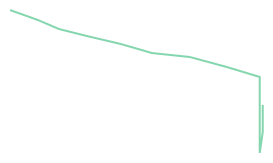

In [3]:
points

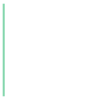

In [36]:
result[2]

In [4]:
len(result)

3

In [5]:
len(shapes_0)

2

In [6]:
len(shapes_1)

1

In [9]:
type(shapes_0[0])

dict

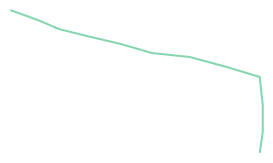

In [80]:
tuples = [(coord_proc_2_x[i], 2030 - coord_proc_2_y[i]) for i in range(len(coord_proc_2_x))]
points = asLineString(tuples)
points

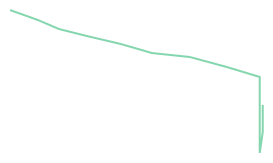

In [81]:
final_points_y_test = [2030 - y for y in final_points_y]
tuples_test = [(final_points_x[i], final_points_y_test[i]) for i in range(len(final_points_x))]
points_test = asLineString(tuples_test)
points_test

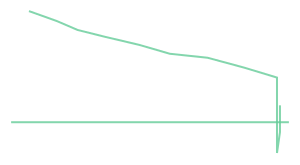

In [83]:
split_line = asLineString([(420, 1015), (700, 1015)])
merge = asMultiLineString([points_test, split_line])
merge

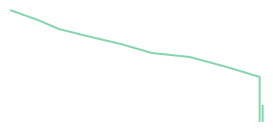

In [84]:
split_line = asLineString([(0, 1015), (1354, 1015)])
results_test = split(points_test, split_line)
merged_split = asMultiLineString([results_test[0], results_test[2]])
merged_split
merged_split

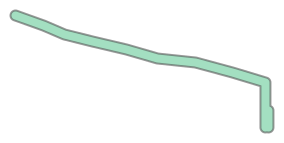

In [106]:
merged_split.buffer(5)

In [86]:
for i in range(len(results_test)):
    print(results_test[i].bounds)
        

(438.0, 1015.0, 688.0, 1127.0)
(688.0, 984.0, 691.0, 1015.0)
(691.0, 1015.0, 691.0, 1032.0)


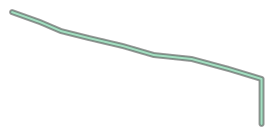

In [93]:
results_test[0].buffer(2)

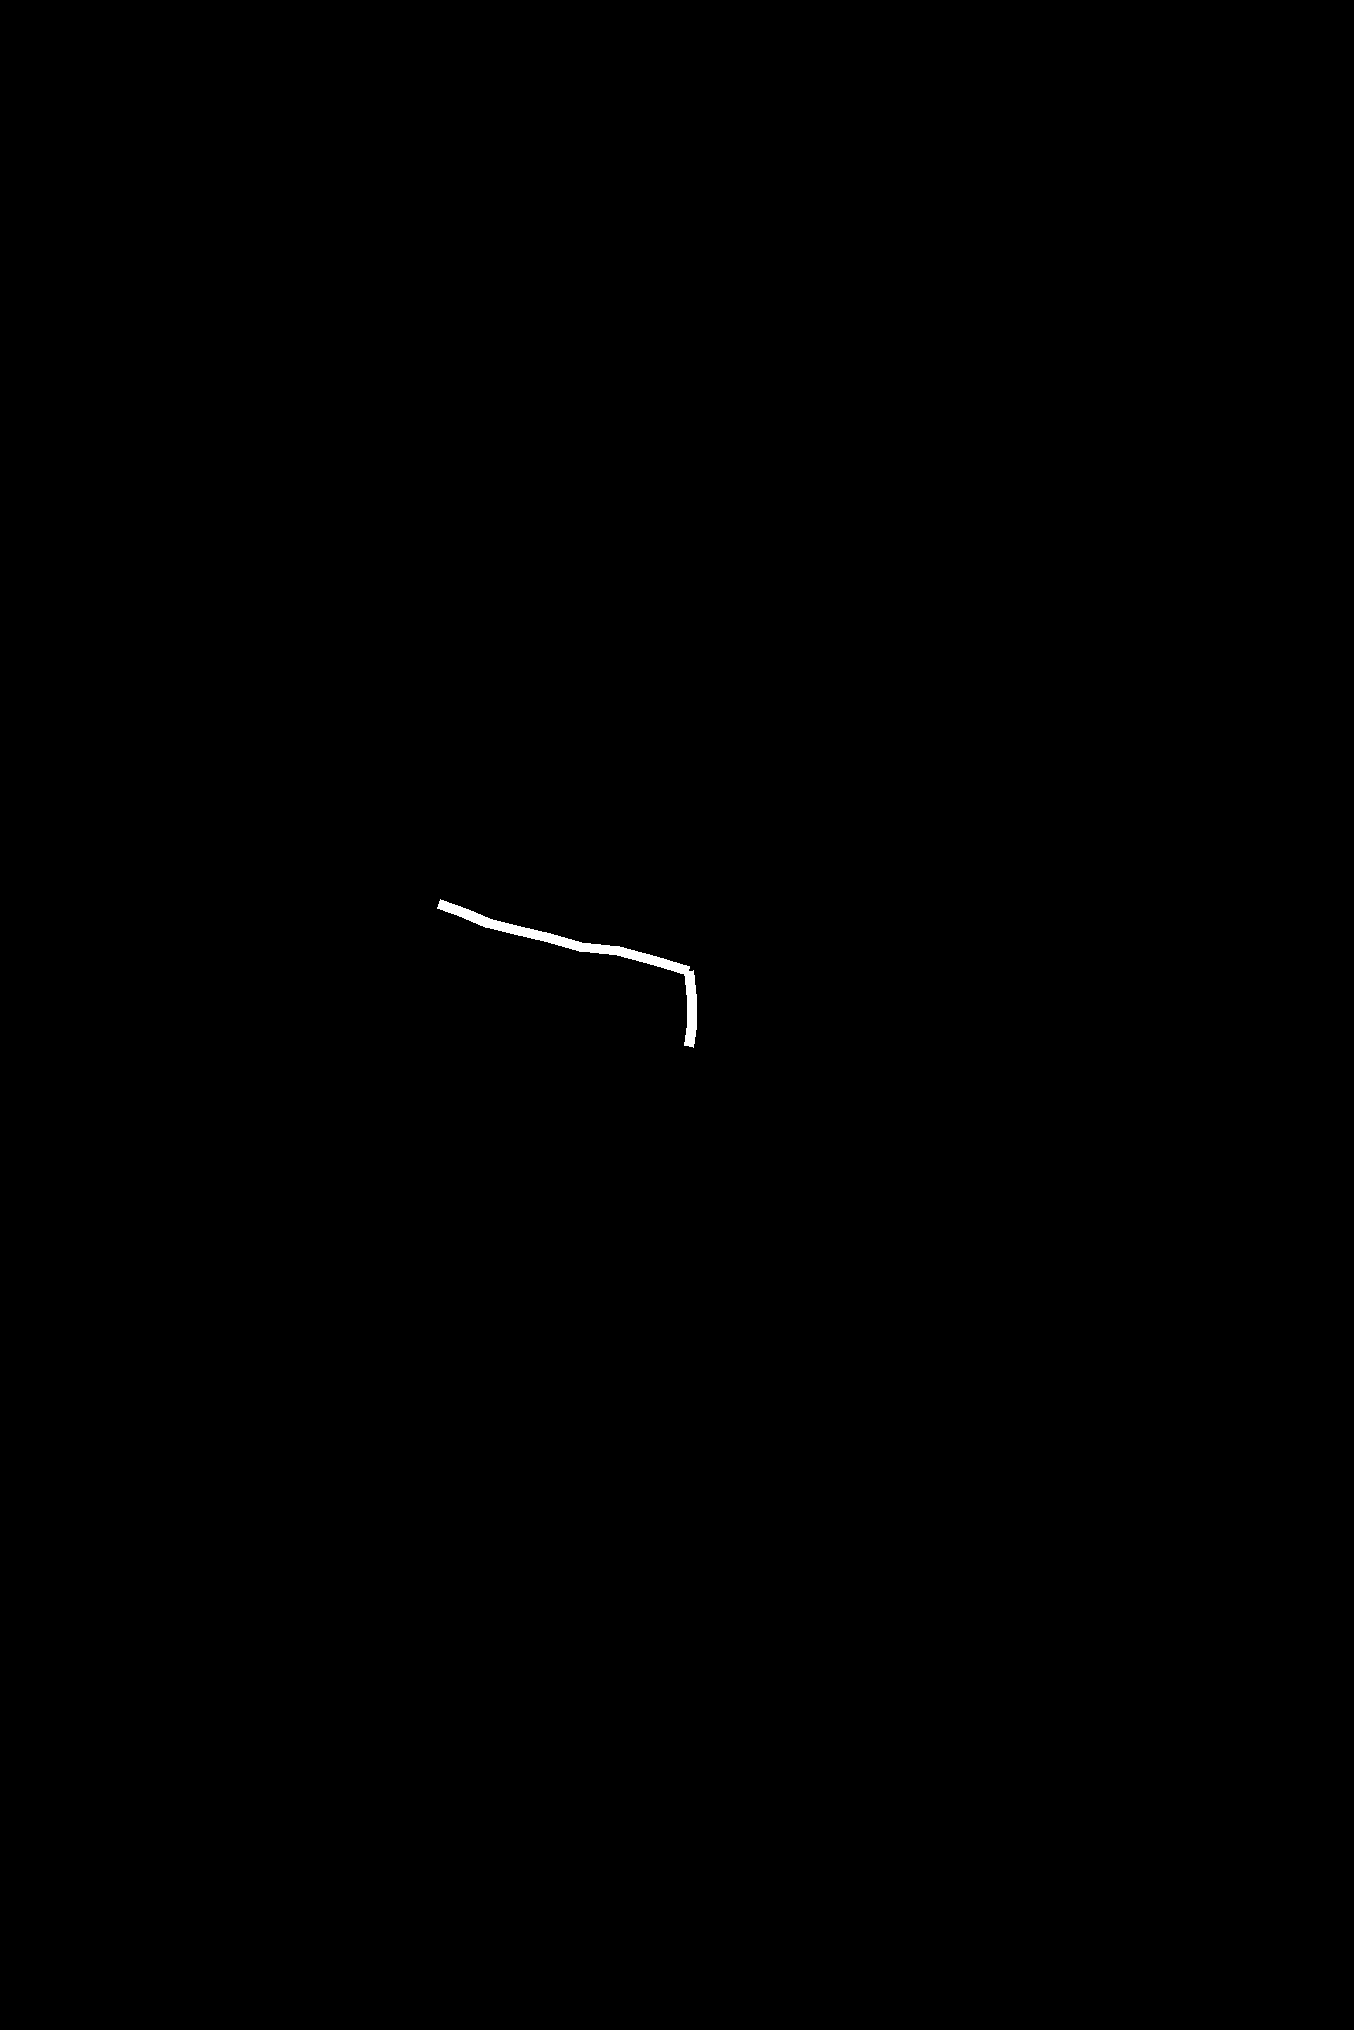

In [105]:
old_shape=(1354,2030)
padding = 0
img = Image.new('L', old_shape, 0)
draw = ImageDraw.Draw(img)

draw.line([c + padding for c in coord_proc_2], fill=255, width=10)

processed_msk = np.abs(np.array(img).astype(int)).astype(np.uint8)
Image.fromarray(processed_msk)

## 7. Coco Format with Smooth and Debugged Masks and Jsons

In [10]:
%reset
import pandas as pd
import string
import shutil
from shutil import copyfile
import mmcv

Nothing done.


In [11]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_smooth_cropped/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [12]:
train_csv = pd.read_csv(train_path)

train_img_dir = DATA_DIR + 'train/images/'

for item in train_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, train_img_dir + image_name)

train_jsons_dir = DATA_DIR + 'train/jsons/'

for item in train_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, train_jsons_dir + json_name)

train_masks_dir = DATA_DIR + 'train/masks/'

for item in train_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, train_masks_dir + mask_name)

In [13]:
val_csv = pd.read_csv(val_path)

val_img_dir = DATA_DIR + 'val/images/'

for item in val_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, val_img_dir + image_name)

val_jsons_dir = DATA_DIR + 'val/jsons/'

for item in val_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, val_jsons_dir + json_name)

val_masks_dir = DATA_DIR + 'val/masks/'

for item in val_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, val_masks_dir + mask_name)

In [14]:
test_csv = pd.read_csv(test_path)

test_img_dir = DATA_DIR + 'test/images/'

for item in test_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, test_img_dir + image_name)

test_jsons_dir = DATA_DIR + 'test/jsons/'

for item in test_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, test_jsons_dir + json_name)

test_masks_dir = DATA_DIR + 'test/masks/'

for item in test_csv.loc[:,'mask']:
    mask_name = item.split("/")[-1]
    shutil.copyfile(item, test_masks_dir + mask_name)

In [3]:
train_jsons_dir = DATA_DIR + 'train/jsons/'

# Getting all train json files
train_jsons = [f for f in os.listdir(train_jsons_dir)]


In [20]:
len(test_csv)

435

In [5]:
for idx in range(1):
    annotation = mmcv.load(train_jsons_dir + train_jsons[1])

In [8]:
annotation['shapes'][0]['points'][0]

[109.33311228437084, 831.4948222243347]

In [57]:
# Train Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(train_jsons)):
    try:
        annotation = mmcv.load(train_jsons_dir + train_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(train_jsons[idx])
    
out_file = DATA_DIR + 'train/train_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

myd2016355.1605D_crop_0.json
myd2016355.1605D_crop_1.json


In [22]:
val_jsons_dir = DATA_DIR + 'val/jsons/'

# Getting all val json files
val_jsons = [f for f in os.listdir(val_jsons_dir)]

# Val Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(val_jsons)):
    try:
        annotation = mmcv.load(val_jsons_dir + val_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(val_jsons[idx])
    
out_file = DATA_DIR + 'val/val_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [23]:
test_jsons_dir = DATA_DIR + 'test/jsons/'

# Getting all test json files
test_jsons = [f for f in os.listdir(test_jsons_dir)]

# Test Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(test_jsons)):
    try:
        annotation = mmcv.load(test_jsons_dir + test_jsons[idx])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(test_jsons[idx])
    
out_file = DATA_DIR + 'test/test_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [51]:
train_annotations = mmcv.load('/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_smooth_cropped/train/train_annotation_coco.json')

In [52]:
len(train_annotations['images'])

3532

In [53]:
i = 0

for idx in range(len(train_csv)):
    if train_csv.loc[idx, 'contains_shiptrack'] == True:
        i+=1

In [54]:
i

2132

In [55]:
image_ids = []
for i in range(len(train_annotations['annotations'])):
    image_ids.append(train_annotations['annotations'][i]['image_id'])


In [56]:
len(set(image_ids))

2125

In [49]:
for idx in range(1):
    print(train_csv.iloc[idx,2])


/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/smooth_jsons_cropped/myd2009321.2255D_crop_0.json


In [61]:
JSONS_PATH = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/smooth_jsons_cropped/'
dir_sorted = os.listdir('/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/smooth_jsons_cropped')

In [64]:
for idx in range(len(dir_sorted)):
    try:
        mmcv.load(JSONS_PATH + dir_sorted[idx])
    except:
        print(dir_sorted[idx])

myd2016355.1605D_crop_1.json
myd2016355.1605D_crop_0.json


## 8. Coco Format with Corrected 500 Masks and Jsons

In [1]:
%reset
import pandas as pd
import string
import shutil
from shutil import copyfile
import mmcv

Nothing done.


In [2]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_corrected_500/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [3]:
train_csv = pd.read_csv(train_path)

train_img_dir = DATA_DIR + 'train/images/'

for item in train_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, train_img_dir + image_name)

# train_jsons_dir = DATA_DIR + 'train/jsons/'

# for item in train_csv.loc[:,'jsons']:
#     json_name = item.split("/")[-1]
#     shutil.copyfile(item, train_jsons_dir + json_name)

# train_masks_dir = DATA_DIR + 'train/masks/'

# for item in train_csv.loc[:,'mask']:
#     mask_name = item.split("/")[-1]
#     shutil.copyfile(item, train_masks_dir + mask_name)

In [5]:
val_csv = pd.read_csv(val_path)

val_img_dir = DATA_DIR + 'val/images/'

for item in val_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, val_img_dir + image_name)

# val_jsons_dir = DATA_DIR + 'val/jsons/'

# for item in val_csv.loc[:,'jsons']:
#     json_name = item.split("/")[-1]
#     shutil.copyfile(item, val_jsons_dir + json_name)

# val_masks_dir = DATA_DIR + 'val/masks/'

# for item in val_csv.loc[:,'mask']:
#     mask_name = item.split("/")[-1]
#     shutil.copyfile(item, val_masks_dir + mask_name)

In [ ]:
# test_csv = pd.read_csv(test_path)

# test_img_dir = DATA_DIR + 'test/images/'

# for item in test_csv.loc[:,'image']:
#     image_name = item.split("/")[-1]
#     shutil.copyfile(item, test_img_dir + image_name)

# test_jsons_dir = DATA_DIR + 'test/jsons/'

# for item in test_csv.loc[:,'jsons']:
#     json_name = item.split("/")[-1]
#     shutil.copyfile(item, test_jsons_dir + json_name)

# test_masks_dir = DATA_DIR + 'test/masks/'

# for item in test_csv.loc[:,'mask']:
#     mask_name = item.split("/")[-1]
#     shutil.copyfile(item, test_masks_dir + mask_name)

In [17]:
# Train Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(train_csv.loc[:,'jsons'])):
    try:
        annotation = mmcv.load(train_csv.loc[idx,'jsons'])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(train_csv.loc[idx,'jsons'])
    
out_file = DATA_DIR + 'train/train_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [ ]:
# Val Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(val_csv.loc[:,'jsons'])):
    try:
        annotation = mmcv.load(val_csv.loc[idx,'jsons'])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(val_csv.loc[idx,'jsons'])
    
out_file = DATA_DIR + 'val/val_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

## 9. Coco Format with Corrected ALL and NULL Masks and Jsons

In [1]:
%reset
import pandas as pd
import string
import shutil
from shutil import copyfile
import mmcv

Nothing done.


In [2]:
DATA_DIR = '/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_corrected_all_w_null/'
train_path = DATA_DIR + 'train.csv'
val_path = DATA_DIR + 'val.csv'
test_path = DATA_DIR + 'test.csv'

In [3]:
train_csv = pd.read_csv(train_path)

train_img_dir = DATA_DIR + 'train/images/'

for item in train_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, train_img_dir + image_name)


In [5]:
train_csv = pd.read_csv(train_path)
train_jsons_dir = DATA_DIR + 'train/jsons/'

for item in train_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, train_jsons_dir + json_name)

# train_masks_dir = DATA_DIR + 'train/masks/'

# for item in train_csv.loc[:,'mask']:
#     mask_name = item.split("/")[-1]
#     shutil.copyfile(item, train_masks_dir + mask_name)

In [4]:
val_csv = pd.read_csv(val_path)

val_img_dir = DATA_DIR + 'val/images/'

for item in val_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, val_img_dir + image_name)


In [6]:
val_csv = pd.read_csv(val_path)

val_jsons_dir = DATA_DIR + 'val/jsons/'

for item in val_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, val_jsons_dir + json_name)

# val_masks_dir = DATA_DIR + 'val/masks/'

# for item in val_csv.loc[:,'mask']:
#     mask_name = item.split("/")[-1]
#     shutil.copyfile(item, val_masks_dir + mask_name)

In [5]:
test_csv = pd.read_csv(test_path)

test_img_dir = DATA_DIR + 'test/images/'

for item in test_csv.loc[:,'image']:
    image_name = item.split("/")[-1]
    shutil.copyfile(item, test_img_dir + image_name)


In [7]:
test_csv = pd.read_csv(test_path)

test_jsons_dir = DATA_DIR + 'test/jsons/'

for item in test_csv.loc[:,'json']:
    json_name = item.split("/")[-1]
    shutil.copyfile(item, test_jsons_dir + json_name)

# test_masks_dir = DATA_DIR + 'test/masks/'

# for item in test_csv.loc[:,'mask']:
#     mask_name = item.split("/")[-1]
#     shutil.copyfile(item, test_masks_dir + mask_name)

In [6]:
# Train Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(train_csv.loc[:,'json'])):
    try:
        annotation = mmcv.load(train_csv.loc[idx,'json'])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(train_csv.loc[idx,'json'])
    
out_file = DATA_DIR + 'train/train_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [7]:
# Val Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(val_csv.loc[:,'json'])):
    try:
        annotation = mmcv.load(val_csv.loc[idx,'json'])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(val_csv.loc[idx,'json'])
    
out_file = DATA_DIR + 'val/val_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

In [8]:
# Test Annotations

annotations = []
images = []
obj_count = 0
for idx in range(len(test_csv.loc[:,'json'])):
    try:
        annotation = mmcv.load(test_csv.loc[idx,'json'])

        filename = annotation['imagePath']
        # print(filename)
        # img_path = osp.join(image_prefix, filename)
        # print(img_path)
        height, width = int(annotation['imageHeight']), int(annotation['imageWidth'])
        # print(height, width)

        images.append(dict(
        id=int(idx),
        file_name=filename,
        height=height,
        width=width))

        bboxes = []
        labels = []
        masks = []
        if len(annotation['shapes']) > 0:
            for obj in annotation['shapes']:
                px = [points[0] for points in obj['points']]
                py = [points[1] for points in obj['points']]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                x_min, y_min, x_max, y_max = (
                    min(px), min(py), max(px), max(py))

                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=0,
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count += 1    
        # else:    
            # No annotations associated in this case
            
            # data_anno = dict(
            #     image_id=idx,
            #     id='',
            #     category_id=0,
            #     bbox=[],
            #     area=0,
            #     segmentation=[],
            #     iscrowd=0)
            # annotations.append(data_anno)
            # obj_count += 1    

    except: 
        print(test_csv.loc[idx,'json'])
    
out_file = DATA_DIR + 'test/test_annotation_coco.json'
coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'shiptrack'}])

mmcv.dump(coco_format_json, out_file)

## 9.1 Checking discrepancy between empty images and empty jsons

In [9]:
train_annotations = mmcv.load('/deep/group/aicc-bootcamp/cloud-pollution/data/combined_v3_typed_new_composite/COCO_corrected_all_w_null/train/train_annotation_coco.json')

In [10]:
len(train_annotations['images'])

2499

In [11]:
i = 0

for idx in range(len(train_csv)):
    if train_csv.loc[idx, 'contains_shiptrack'] == True:
        i+=1
print(i)

1433


In [12]:
image_ids = []
for i in range(len(train_annotations['annotations'])):
    image_ids.append(train_annotations['annotations'][i]['image_id'])

len(set(image_ids))


1427